In [1]:
# import libraries
import numpy as np
import pandas as pd
import dionysus as d
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import random
import numpy as np

%matplotlib widget

In [2]:
# define the classes
class Point:
    id: int
    coord: np.ndarray
    dominant: int
    value: float
    tissue: bool
    valid: bool
    # edges_belonged: set[int] = set()
    # triangles_belonged: set[int] = set()
    # tets_belonged: set[int] = set()

point_list: list[Point] = []
edge_set: set[tuple[int]] = set()
triangle_set: set[tuple[int]] = set()
tetrahedron_set: set[tuple[int]] = set()


Run either data import or test data generation code block, but not both

In [3]:
# load from data files
# points_data = pd.read_csv("points.csv")
# tets_data = pd.read_csv("tets.csv")

In [4]:
# generate test data
# torus parameters
R = 4
r = 0.5
num_points = 10000


width = 2 * (R + r)
height = 2 * r


# test if a point is inside the torus
def torus(x, y, z):
    return (R - np.sqrt(x**2 + y**2)) ** 2 + z**2 < r**2


# generate random points in the bounding box of the torus, with a random value appended
points = np.array([p for p in np.random.rand(num_points, 3) * [width, width, height] - [R + r, R + r, r] if torus(*p)])

# delauany tetrahedralization
tets_data = pd.DataFrame(Delaunay(points).simplices)

# generate random values for each point
values = pd.DataFrame(np.random.rand(len(points), 2))
points_data = pd.concat([pd.DataFrame(points), values], axis=1)

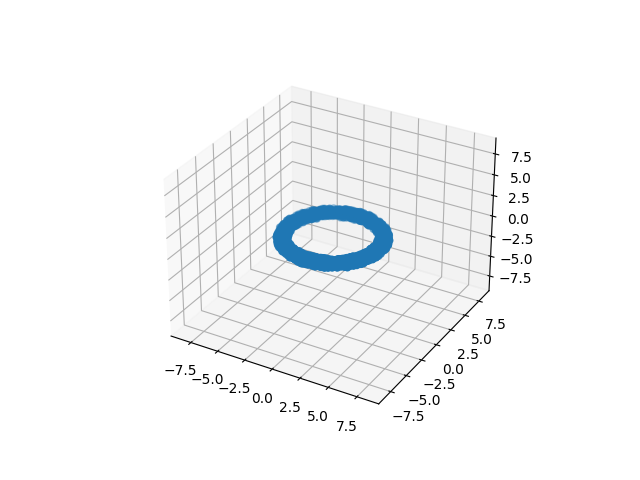

In [14]:
# plot the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_data.iloc[:, 0].to_numpy(), points_data.iloc[:, 1].to_numpy(), points_data.iloc[:, 2].to_numpy())
# ax.set_box_aspect([width,width,width])
ax.set_xlim3d(-width, width)
ax.set_ylim3d(-width, width)
ax.set_zlim3d(-width, width)

plt.show()

In [6]:
num_materials = points_data.shape[1] - 3

for i, row in points_data.iterrows():
    point = Point()
    point.id = i
    point.coord = row.iloc[:3]
    values = row.iloc[3:]
    point.dominant = np.argmax(values)
    values_sorted = sorted(values)
    point.value = values_sorted[-1] - values_sorted[-2]
    point.tissue = point.dominant != num_materials - 1
    point.valid = not pd.isna(point.value) and point.tissue
    point_list.append(point)

edge_combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
triangle_combinations = [
    (0, 1, 2),
    (0, 1, 3),
    (0, 2, 3),
    (1, 2, 3),
]


def same_material(point_indices):
    return all([point_list[point].dominant == point_list[point_indices[0]].dominant for point in point_indices])


def all_valid(point_indices):
    return all([point_list[point].valid for point in point_indices])


for i, tet in tets_data.iterrows():
    edges = [sorted([tet[x[0]], tet[x[1]]]) for x in edge_combinations]
    [edge_set.add(tuple(x)) for x in edges if same_material(x) and all_valid(x)]
    triangles = [sorted([tet[x[0]], tet[x[1]], tet[x[2]]]) for x in triangle_combinations]
    [triangle_set.add(tuple(x)) for x in triangles if same_material(x) and all_valid(x)]
    if same_material(tet) and all_valid(tet):
        tetrahedron_set.add(tuple(sorted(tet)))

In [7]:

valid_point_list = [point for point in point_list if point.valid]

def get_time(point_indices):
    return 1 - min([point_list[point].value for point in point_indices])

# group the points by material
points_by_material = [[] for _ in range(num_materials)]
edges_by_material = [[] for _ in range(num_materials)]
triangles_by_material = [[] for _ in range(num_materials)]
tets_by_material = [[] for _ in range(num_materials)]
for point in valid_point_list:
    points_by_material[point.dominant].append(([point.id], 1 - point.value))
for edge in edge_set:
    edges_by_material[point_list[edge[0]].dominant].append((list(edge), get_time(edge)))
for triangle in triangle_set:
    triangles_by_material[point_list[triangle[0]].dominant].append((list(triangle), get_time(triangle)))
for tet in tetrahedron_set:
    tets_by_material[point_list[tet[0]].dominant].append((list(tet), get_time(tet)))


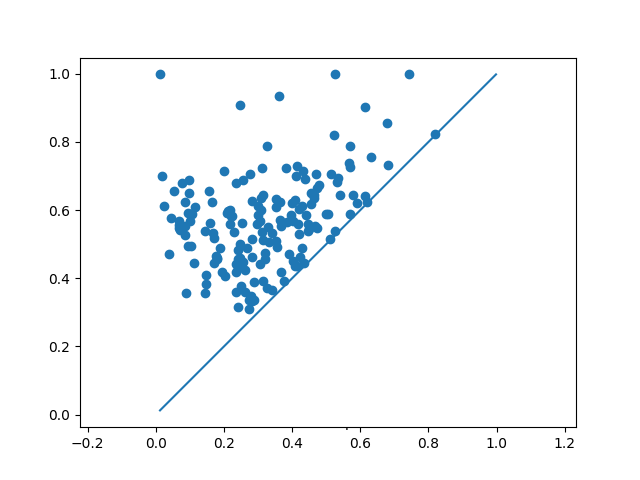

In [8]:
# iterate through the materials
for material in range(num_materials):
    if len(points_by_material[material]) == 0:
        continue

    simplices = []
    simplices.extend(points_by_material[material])
    simplices.extend(edges_by_material[material])
    simplices.extend(triangles_by_material[material])
    simplices.extend(tets_by_material[material])

    filtration = d.Filtration()
    for vertices, time in simplices:
        filtration.append(d.Simplex(vertices, time))
    filtration.sort()

    ph_matrix = d.homology_persistence(filtration)
    diagrams = d.init_diagrams(ph_matrix, filtration)
    # for i, diagram in enumerate(diagrams):
    #     for pt in diagram:
    #         print(i, pt.birth, pt.death)
    d.plot.plot_diagram(diagrams[0], show=True)